In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from pathlib import Path
from torch.utils.data import DataLoader

from torchfitter import io
from torchfitter.trainer import Trainer
from torchfitter.utils import DataWrapper
from torchfitter.regularization import L1Regularization
from torchfitter.callbacks import LoggerCallback, EarlyStopping, LearningRateScheduler

from sklearn.model_selection import train_test_split

torch.manual_seed(0)
np.random.seed(0)

In [3]:
DATA_PATH = Path(os.path.abspath('')).parent / "tests/data"

In [4]:
def experiment_func(seed, folder_name):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    subfolder = folder_name / f"experiment_{seed}"
    
    if f"experiment_{seed}" not in os.listdir(folder_name):
        os.mkdir(subfolder)
    
    # ---------------------------------------------------------------------
    # split
    X = np.load(DATA_PATH / "features.npy")
    y = np.load(DATA_PATH / "labels.npy")
    y = y.reshape(-1,1)
    
    # simplest case of cross-validation
    X_train, X_val, y_train, y_val = train_test_split(
        X, 
        y, 
        test_size=0.33, 
        random_state=42
    )
    
    # wrap data in Dataset
    train_wrapper = DataWrapper(
        X_train, 
        y_train, 
        dtype_X='float', 
        dtype_y='float'
    )
    val_wrapper = DataWrapper(
        X_val,
        y_val,
        dtype_X='float',
        dtype_y='float'
    )

    # torch Loaders
    train_loader = DataLoader(train_wrapper, batch_size=64, pin_memory=True)
    val_loader = DataLoader(val_wrapper, batch_size=64, pin_memory=True)

    # ---------------------------------------------------------------------
    # model creatiom
    model = nn.Linear(in_features=1, out_features=1)
    model.to(device)
    
    # optimization settings 
    regularizer = L1Regularization(regularization_rate=0.01, biases=False)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    
    # ---------------------------------------------------------------------
    callbacks = [
        LoggerCallback(update_step=100),
        EarlyStopping(patience=50, load_best=False, path=subfolder / 'checkpoint.pt'),
        LearningRateScheduler(
            scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)
        )
    ]

    # trainer
    trainer = Trainer(
        model=model, 
        criterion=criterion,
        optimizer=optimizer, 
        regularizer=regularizer,
        device=device,
        callbacks=callbacks,
    )
    
    # run training
    trainer.fit(train_loader, val_loader, 5000, disable_pbar=True)
    
    # ---------------------------------------------------------------------
    # model state
    torch.save(trainer.model.state_dict(), subfolder / 'model_state.pt')
    
    # optim state
    torch.save(trainer.optimizer.state_dict(), subfolder / 'optim_state.pt')
    
    # history
    io.save_pickle(
        obj=trainer.internal_state.get_state_dict()['history'],
        path=subfolder / 'history.pkl'
    )

----

In [5]:
from torchfitter.manager import Manager

In [6]:
# define random seeds
seeds = (0, 5, 10)
folder = Path('experiments')

manager = Manager(
    seeds=seeds,
    folder_name=folder
)

In [7]:
manager.run_experiments(experiment_func=experiment_func)

INFO:root:Starting training process on cuda
INFO:root:End of training. Total time: 131.10460 seconds
INFO:root:Early stopping applied at epoch: 2941
INFO:root:Starting training process on cuda
INFO:root:End of training. Total time: 132.64933 seconds
INFO:root:Early stopping applied at epoch: 2922
INFO:root:Starting training process on cuda
INFO:root:End of training. Total time: 134.16150 seconds
INFO:root:Early stopping applied at epoch: 2943


In [9]:
from torchfitter.io import load_pickle

In [10]:
experiments = {}

for seed in seeds:
    mod = torch.load(folder / f'experiment_{seed}/model_state.pt')
    best = torch.load(folder / f'experiment_{seed}/checkpoint.pt')
    op = torch.load(folder / f'experiment_{seed}/optim_state.pt')
    hist = load_pickle(folder / f'experiment_{seed}/history.pkl')
    
    experiments[seed] = {}
    
    experiments[seed]['model'] = mod
    experiments[seed]['best_model'] = best
    experiments[seed]['optimizer'] = op
    experiments[seed]['history'] = hist

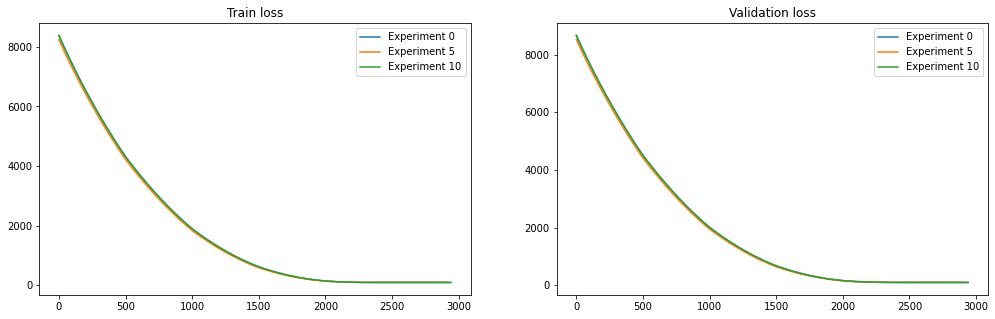

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))

for key in experiments.keys():
    hist = experiments[key]['history']
    
    ax[0].plot(hist['train_loss'], label=f'Experiment {key}')
    ax[0].set_title('Train loss')
    ax[0].legend()
    
    ax[1].plot(hist['validation_loss'], label=f'Experiment {key}')
    ax[1].set_title('Validation loss')
    ax[1].legend()

----

In [12]:
experiments[0]['model']

OrderedDict([('weight', tensor([[90.8703]], device='cuda:0')),
             ('bias', tensor([0.0947], device='cuda:0'))])

In [13]:
experiments[0]['best_model']

OrderedDict([('weight', tensor([[90.8704]], device='cuda:0')),
             ('bias', tensor([0.0947], device='cuda:0'))])

---

In [14]:
experiments[5]['model']

OrderedDict([('weight', tensor([[90.8703]], device='cuda:0')),
             ('bias', tensor([0.0947], device='cuda:0'))])

In [15]:
experiments[5]['best_model']

OrderedDict([('weight', tensor([[90.8704]], device='cuda:0')),
             ('bias', tensor([0.0947], device='cuda:0'))])

----

In [16]:
experiments[10]['model']

OrderedDict([('weight', tensor([[90.8703]], device='cuda:0')),
             ('bias', tensor([0.0947], device='cuda:0'))])

In [17]:
experiments[10]['best_model']

OrderedDict([('weight', tensor([[90.8704]], device='cuda:0')),
             ('bias', tensor([0.0947], device='cuda:0'))])

---